In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import choice
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression

In [2]:
# Load data
data = loadmat('./ex5data1.mat')
X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']
print(X.shape)
print(y.shape)

(12, 1)
(12, 1)


### 1.1 Visualizing the dataset

In [3]:
def plot_data(X, y, label_x, label_y, axes=None):
    if not axes:
        axes = plt.gca()
    axes.scatter(X,y, label='Training data', marker='x')
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend()

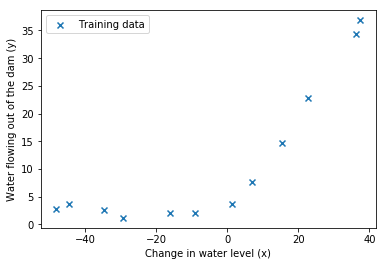

In [4]:
plot_data(X, y, 'Change in water level (x)', 'Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function

In [5]:
def linear_reg_cost_function(theta, X, y, lamb=1):
    m = len(y)
    hx = X.dot(theta.reshape(-1,1))
    J = (1/(2*m))*(np.sum(np.square(hx-y))) + (lamb/(2*m))*(np.sum(np.square(theta[1:])))
    
    return J

In [6]:
def linear_reg_gradient(theta, X, y, lamb=1):
    m = len(y)
    hx = X.dot(theta.reshape(-1,1))
    grad = (1/m)*((hx-y).T.dot(X)) + (lamb/m)*(np.c_[[0],[theta[1:]]])
    
    return grad.flatten()

In [7]:
X_in = np.c_[np.ones((X.shape[0],1)), X]
theta_init = np.ones((X_in.shape[1]))

In [8]:
cost = linear_reg_cost_function(theta_init, X_in, y, 1)
grad = linear_reg_gradient(theta_init, X_in, y, 1)
print(cost)
print(grad)

303.9931922202643
[-15.30301567 598.25074417]


### 1.4 Fitting linear regression

In [9]:
def train_linear_reg(X, y, lamb):
    theta = np.ones((X.shape[1]))
    res = minimize(linear_reg_cost_function, theta, method='CG', args=(X,y,lamb), \
                   jac=linear_reg_gradient, options={'disp': False})
    
    return res.x

In [10]:
theta = train_linear_reg(X_in, y, 0)

In [11]:
def predict(theta, X):
#     X_2d = X.reshape(-1,1)
#     X_in = np.c_[np.ones((X_2d.shape[0],1)), X_2d]
    return X.dot(theta.reshape(-1,1)).flatten()

In [12]:
def plot_fit(theta, X, y, axes=None):
    X_min, X_max = np.min(X), np.max(X)
    plot_X = np.linspace(X_min, X_max).reshape(-1,1)
    X_in = np.c_[np.ones((plot_X.shape[0],1)), plot_X]
    plot_y = predict(theta, X_in)
    if axes == None:
        axes = plt.gca()
    axes.plot(plot_X.flatten(), plot_y,label='Linear fit', color='r')
    plot_data(X, y, 'Change in water level (x)', 'Water flowing out of the dam (y)', axes)

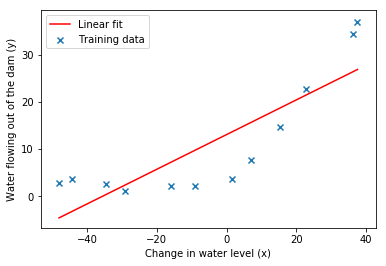

In [13]:
plot_fit(theta, X, y)

### 2.1 Learning curves

In [14]:
def evaluate(ground_truth, prediction):
    return np.mean(np.square(ground_truth.ravel() - prediction.ravel()))/2

In [37]:
def learning_curve(X, y, Xval, yval, lamb):
    m = len(y)
    error_train = []
    error_val = []
    for i in range(1, m):
        X_in = np.c_[np.ones((i, 1)), X[:i]]
        y_in = y[:i]
        Xval_in = np.c_[np.ones((Xval.shape[0],1)), Xval]
        theta = train_linear_reg(X_in, y_in, lamb)
        
        error_train.append(linear_reg_cost_function(theta, X_in, y_in, lamb))
        error_val.append(linear_reg_cost_function(theta, Xval_in, yval, lamb))
        
    return error_train, error_val

In [38]:
error_train, error_val = learning_curve(X, y, Xval, yval, 1)

In [39]:
def plot_learning_curve(error_train, error_val, axes=None):
    if axes == None:
        axes = plt.gca()
        
    axes.plot(np.linspace(1, len(error_train), len(error_train)), error_train, label='Train')
    axes.plot(np.linspace(1, len(error_val), len(error_val)), error_val, label='Cross Validation')
    axes.set_xlabel('Number of training examples')
    axes.set_ylabel('Error')
    axes.legend()

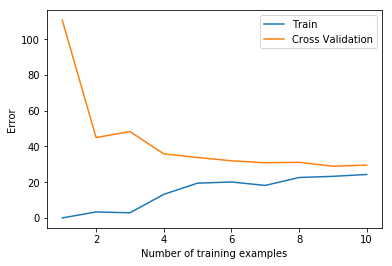

In [40]:
plot_learning_curve(error_train[1:], error_val[1:])

### 3 Polynomial regression

In [19]:
def poly_features(X, p):
    X_poly = np.array(X)
    for i in range(2, p+1):
        X_poly = np.c_[X_poly, np.power(X, i)]
    return X_poly

In [20]:
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X , axis=0)
    X_norm = (X - mu)/sigma
    
    return X_norm, mu, sigma

In [21]:
def feature_normalize_with_params(X, mu, sigma):
    return (X - mu)/sigma

In [22]:
p = 8
X_poly, mu, sigma = feature_normalize(poly_features(X, p))
X_poly = np.c_[np.ones((X_poly.shape[0],1)), X_poly]

X_poly_test = feature_normalize_with_params(poly_features(Xtest, p), mu, sigma)
X_poly_test = np.c_[np.ones((X_poly_test.shape[0],1)), X_poly_test]

X_poly_val = feature_normalize_with_params(poly_features(Xval, p), mu, sigma)
X_poly_val = np.c_[np.ones((X_poly_val.shape[0],1)), X_poly_val]

### 3.1 Learning Polynomial Regression

In [23]:
theta_poly = train_linear_reg(X_poly, y, 0)

In [24]:
reg = LinearRegression().fit(X_poly, y)

In [25]:
def plot_fit(min_x, max_x, p, theta=None, r=None, axes=None):
    x = np.linspace(min_x-15, max_x+10).reshape(-1,1)
    X_poly = feature_normalize_with_params(poly_features(x, p), mu, sigma)
    X_poly = np.c_[np.ones((X_poly.shape[0],1)), X_poly]
    pred = X_poly.dot(theta) if not r else r.predict(X_poly)
    if axes == None:
        axes = plt.gca()
    axes.plot(x, pred, label='Poly fit, p = 8', color='r')
    plot_data(X, y, 'Change in water level (x)', 'Water flowing out of the dam (y)', axes)

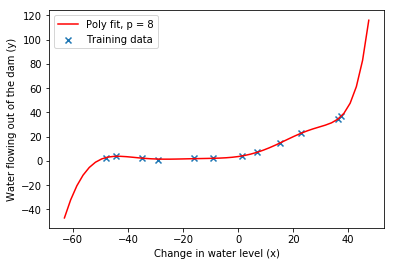

In [26]:
plot_fit(np.min(X), np.max(X), p, theta=theta_poly)

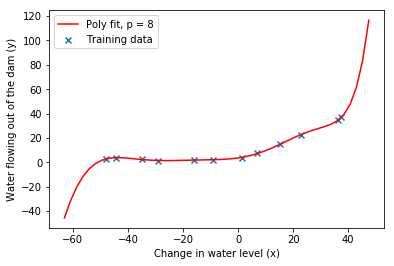

In [27]:
plot_fit(np.min(X), np.max(X), p, r=reg)

In [28]:
error_train_poly, error_val_poly = learning_curve(X_poly, y, X_poly_val, yval, 0)

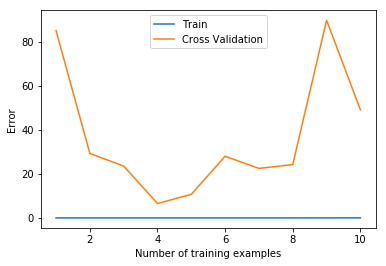

In [29]:
plot_learning_curve(error_train_poly[1:], error_val_poly[1:])

### 3.2 Adjusting the regularization parameter

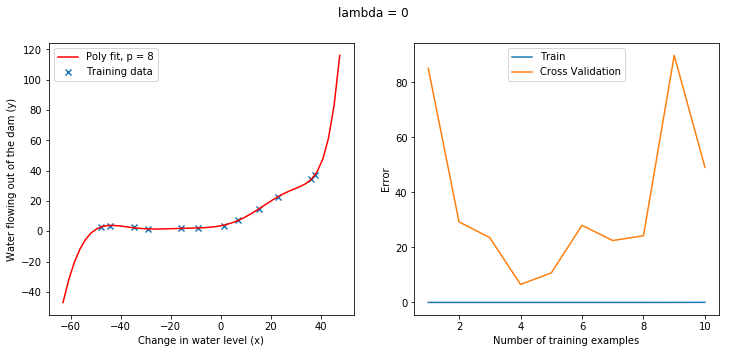

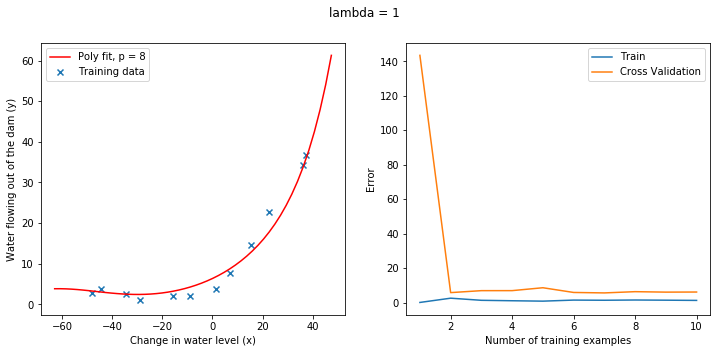

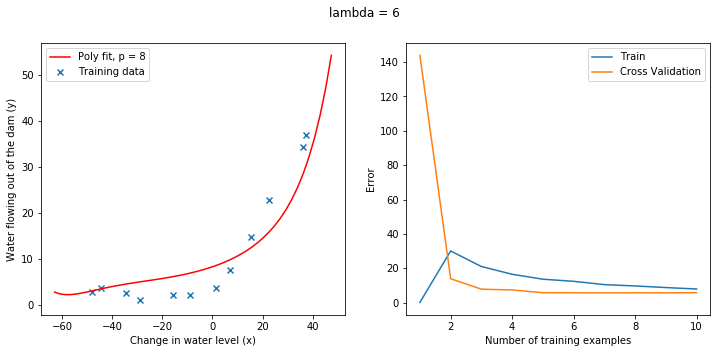

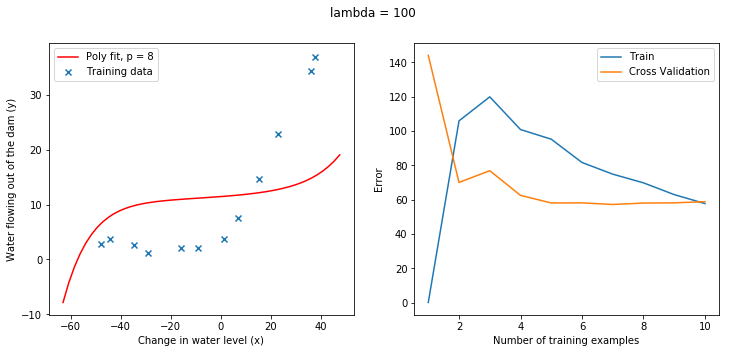

In [30]:
lambs = [0,1,6,100]
for i in range(len(lambs)):
    lamb = lambs[i]
    theta_poly = train_linear_reg(X_poly, y, lamb)
    error_train_poly, error_val_poly = learning_curve(X_poly, y, X_poly_val, yval, lamb)
    
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    fig.suptitle('lambda = {}'.format(lamb))
    plot_fit(np.min(X), np.max(X), p, theta=theta_poly, axes=ax[0])
    plot_learning_curve(error_train_poly[1:], error_val_poly[1:], axes=ax[1])

### 3.3 Selecting lambda using a cross validation set

In [31]:
def validation_curve(X, y, Xval, yval):
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = []
    error_val = []
    for i in range(len(lambda_vec)):
        lamb = lambda_vec[i]
        X_in = np.c_[np.ones((X.shape[0],1)), X]
        Xval_in = np.c_[np.ones((Xval.shape[0],1)), Xval]
        
        theta = train_linear_reg(X_in, y, lamb)
        
        pred_train = predict(theta, X_in)
        pred_val = predict(theta, Xval_in)
        error_train.append(evaluate(y, pred_train))
        error_val.append(evaluate(yval, pred_val))
        
    return lambda_vec, error_train, error_val

In [32]:
def plot_validation_curve(error_train, error_val, axes=None):
    if axes == None:
        axes = plt.gca()
    axes.plot(error_train, label='Train')
    axes.plot(error_val, label='Cross Validation')
    axes.set_xlabel('lambda')
    axes.set_ylabel('Error')
    axes.legend()

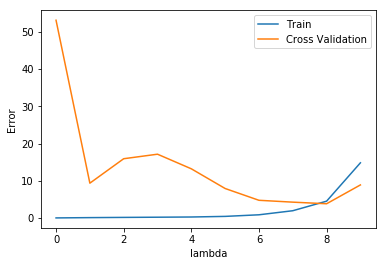

In [33]:
lambda_vec, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)
plot_validation_curve(error_train, error_val)

### 3.4 Computing test set error

In [34]:
theta_poly = train_linear_reg(X_poly, y, 1)
pred_test = predict(theta_poly, X_poly_test)
evaluate(ytest, pred_test)

2.780005441287523